In [1]:
import pandas as pd

# Replace this with the path to your dataset
file_path = 'data/merged_vlp_otd_anonimized.csv'
df = pd.read_csv(file_path)


# Convert order_close_date to datetime
df['order_close_date'] = pd.to_datetime(df['order_close_date'])

# Now proceed with the churn calculation as before

# Display the first few rows of the dataframe to understand its structure
print(df.head())




   source_id    birthday  month_order  year_order                     ornum  \
0   61675290  2021-09-17            7        2023  61675290_143351339940541   
1   44578735  2021-04-09            7        2023    44578735_7798210436244   
2   32696268  2021-01-08            7        2023    32696268_4951711420874   
3  135039595  2022-03-31            7        2023  135039595_32785480989704   
4  228885181  2022-10-07            7        2023  228885181_54824912230348   

  order_close_date city     segmento   gmv_on_3  active  ...  \
0       2023-07-28  SPO  Restaurante   32.37042    True  ...   
1       2023-07-28  SPO  Restaurante   84.43154    True  ...   
2       2023-07-28  SPO  Restaurante   56.48729    True  ...   
3       2023-07-28  SPO  Restaurante   83.47472    True  ...   
4       2023-07-28  SPO  Restaurante  108.02103    True  ...   

   reactivation_status  microzone_source_id warehouse  deliver_date  \
0                 None                149.0       VLP    2023-07-28  

In [2]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np

def calculate_churn_status(df, reference_date):
    # Filter data for the last three months
    start_date = reference_date - relativedelta(months=3)
    filtered_df = df[(df['order_close_date'] >= start_date) & (df['order_close_date'] < reference_date)]

    # Calculate purchase frequency for each customer
    freq_df = filtered_df.groupby('source_id')['order_close_date'].agg(['count', 'max'])
    freq_df.rename(columns={'count': 'purchase_count', 'max': 'last_purchase_date'}, inplace=True)
    freq_df['days_since_last_purchase'] = (reference_date - freq_df['last_purchase_date']).dt.days
    freq_df['average_purchase_frequency'] = freq_df['days_since_last_purchase'] / freq_df['purchase_count']

    # Apply churn rule
    freq_df['is_churn'] = np.where(
        (freq_df['days_since_last_purchase'] > (freq_df['average_purchase_frequency'] * 1.25)) |
        (freq_df['purchase_count'] == 0),
        True,
        False
    )

    return freq_df[['purchase_count', 'last_purchase_date', 'average_purchase_frequency', 'is_churn']]


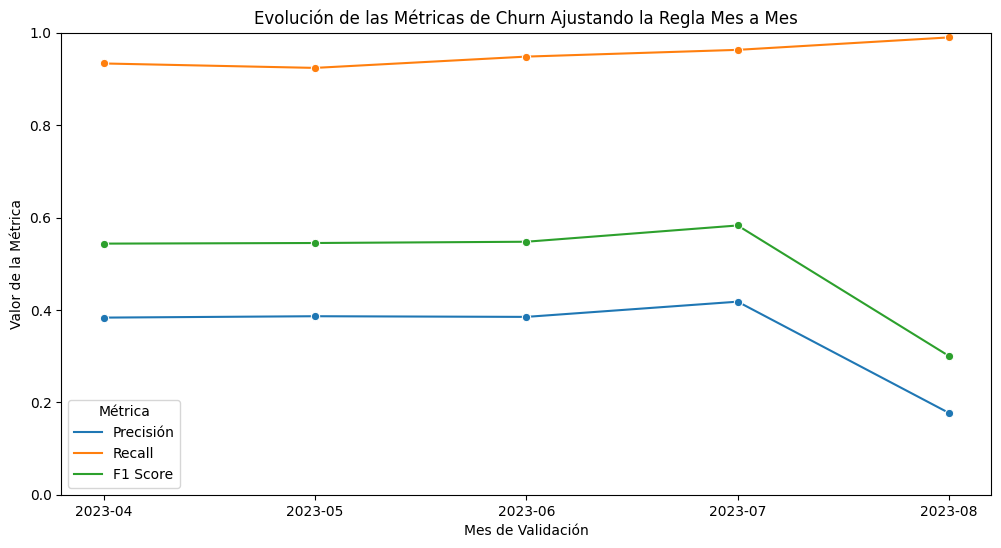

In [3]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Carga de datos
file_path = 'data/merged_vlp_otd_anonimized.csv'
df = pd.read_csv(file_path)
df['order_close_date'] = pd.to_datetime(df['order_close_date'])

# Definición de la función para calcular el estado de churn
def calculate_churn_status(df, reference_date):
    start_date = reference_date - relativedelta(months=3)
    filtered_df = df[(df['order_close_date'] >= start_date) & (df['order_close_date'] < reference_date)]

    freq_df = filtered_df.groupby('customer_id')['order_close_date'].agg(['count', 'max'])
    freq_df.rename(columns={'count': 'purchase_count', 'max': 'last_purchase_date'}, inplace=True)
    freq_df['days_since_last_purchase'] = (reference_date - freq_df['last_purchase_date']).dt.days
    freq_df['average_purchase_frequency'] = freq_df['days_since_last_purchase'] / freq_df['purchase_count']

    freq_df['is_churn'] = np.where(
        (freq_df['days_since_last_purchase'] > (freq_df['average_purchase_frequency'] * 1.25)) |
        (freq_df['purchase_count'] == 0),
        True,
        False
    )
    freq_df.reset_index(inplace=True)
    return freq_df[['customer_id', 'purchase_count', 'last_purchase_date', 'average_purchase_frequency', 'is_churn']]

# Análisis iterativo y cálculo de métricas
precisions, recalls, f1_scores = [], [], []
for month in range(3, 8):
    reference_date = datetime(2023, month, 1) + relativedelta(months=1) - relativedelta(days=1)
    churn_status_df = calculate_churn_status(df, reference_date)

    # Estado real de churn para el próximo mes
    next_month_reference_date = reference_date + relativedelta(months=1)
    actual_churn_df = df[df['order_close_date'] >= next_month_reference_date].copy()
    actual_churn_df['real_purchase'] = actual_churn_df.index.isin(churn_status_df['customer_id'])
    actual_churn_df['real_churn'] = ~actual_churn_df['real_purchase']
    merged_df = churn_status_df.merge(actual_churn_df[['customer_id', 'real_churn']], how='left', on='customer_id')
    merged_df.drop_duplicates(subset='customer_id', inplace=True)
    merged_df['real_churn'].fillna(False, inplace=True)

    precision = precision_score(merged_df['real_churn'], merged_df['is_churn'])
    recall = recall_score(merged_df['real_churn'], merged_df['is_churn'])
    f1 = f1_score(merged_df['real_churn'], merged_df['is_churn'])

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Preparación de datos para la visualización
months = [f'2023-{month:02d}' for month in range(4, 9)]
visualization_data = pd.DataFrame({'Mes': months, 'Precisión': precisions, 'Recall': recalls, 'F1 Score': f1_scores})
visualization_data_melted = pd.melt(visualization_data, id_vars='Mes', value_vars=['Precisión', 'Recall', 'F1 Score'],
                                    var_name='Métrica', value_name='Valor')

# Creación del gráfico de líneas
plt.figure(figsize=(12, 6))
sns.lineplot(x='Mes', y='Valor', hue='Métrica', data=visualization_data_melted, marker='o')
plt.title('Evolución de las Métricas de Churn Ajustando la Regla Mes a Mes')
plt.xlabel('Mes de Validación')
plt.ylabel('Valor de la Métrica')
plt.ylim(0, 1)
plt.legend(title='Métrica')
plt.show()
